In [ ]:
import os
import shutil
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import tarfile
import nibabel as nib
import random

from tqdm import tqdm
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K
from sklearn.model_selection import train_test_split
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage.transform import resize
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage.io import imread
from scipy import ndimage as ndi
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from glob import glob

from keras import Input, Model
from keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
)
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import models, layers, regularizers, optimizers, losses, metrics
from keras.losses import CategoricalCrossentropy

from sklearn.preprocessing import MinMaxScaler

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam

import glob
import os
import random
import shutil

DEVICE = "GPU"

In [ ]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


In [ ]:
# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def sensitivity(y_true, y_pred):
    num_classes = 4
    sensitivities = []
    for i in range(num_classes):
        true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true[..., i] * y_pred[..., i], 0, 1)))
        possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true[..., i], 0, 1)))
        sensitivity = true_positives / (possible_positives + tf.keras.backend.epsilon())
        sensitivities.append(sensitivity)
    return tf.reduce_mean(sensitivities)

# Accuracy vs Epoch
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25, wspace=0.35)
    plt.show()

# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25, wspace=0.35)
    plt.show()

# Loss vs Epoch
def Loss_Graph(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25, wspace=0.35)
    plt.show()

In [ ]:
def load_img(img_dir, img_list):
    images = []
    for image_name in img_list:
        if image_name.endswith('.npy'):
            image = np.load(os.path.join(img_dir, image_name))
            images.append(image)
    images = np.array(images)
    return images

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])
            yield (X, Y)
            batch_start += batch_size
            batch_end += batch_size

In [ ]:
!rm -Rf ./post_process_data
!rm -Rf ./data
!rm -Rf ./final_models

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download dschettler8845/brats-2021-task1
! unzip /content/brats-2021-task1.zip

100% 12.3G/12.3G [07:22<00:00, 29.8MB/s]
100% 12.3G/12.3G [07:22<00:00, 29.8MB/s]
Archive:  /content/brats-2021-task1.zip
  inflating: BraTS2021_00495.tar     
  inflating: BraTS2021_00621.tar     
  inflating: BraTS2021_Training_Data.tar  


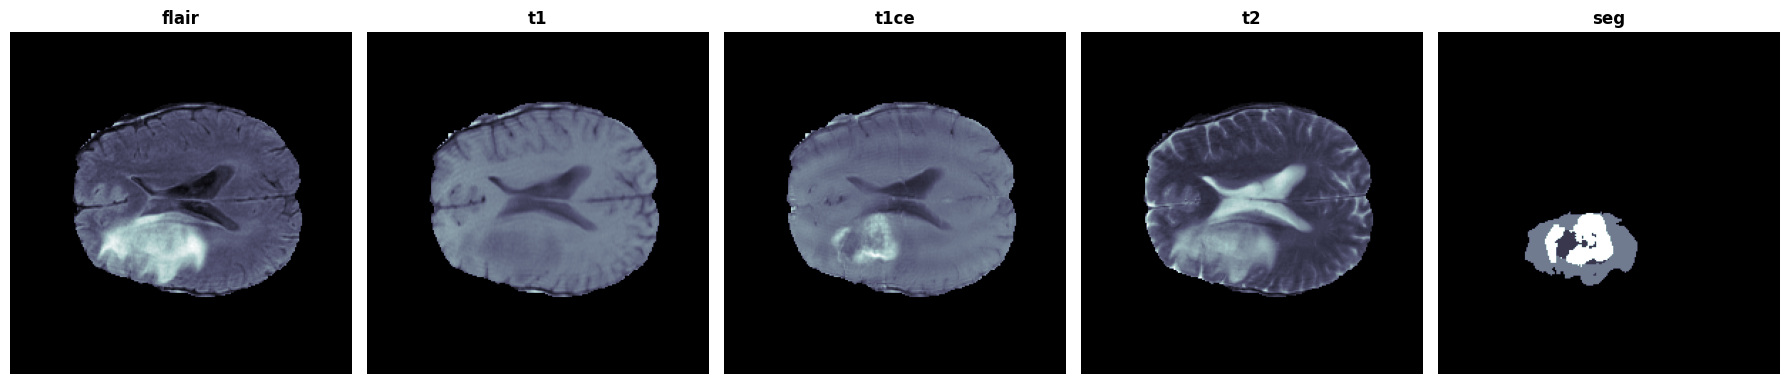

In [ ]:
!mkdir data
!mkdir final_models

# Extract the training data files
tar = tarfile.open("/content/BraTS2021_Training_Data.tar")
tar.extractall("./data")
tar.close()

img_id = "01281"
plt.figure(figsize=(18, 5))
for i, nii in enumerate([f'./data/BraTS2021_{img_id}/BraTS2021_{img_id}_{s_type}.nii.gz' for s_type in ["flair", "t1", "t1ce", "t2", "seg"]]):
    plt.subplot(1,5,i+1)
    image=nib.load(nii).get_fdata()
    plt.title(nii.rsplit("_", 1)[1].split(".", 1)[0], fontweight="bold")
    plt.axis(False)
    plt.imshow(image[:, :, 80], cmap="bone")
plt.tight_layout()
plt.show()

In [ ]:
def data_preprocess(data_path):
    scaler = MinMaxScaler()

    # Define the paths to the dataset files
    t2_list = sorted(glob.glob(data_path + '/**/*t2.nii.gz', recursive=True))
    t1ce_list = sorted(glob.glob(data_path + '/**/*t1ce.nii.gz', recursive=True))
    flair_list = sorted(glob.glob(data_path + '/**/*flair.nii.gz', recursive=True))
    mask_list = sorted(glob.glob(data_path + '/**/*seg.nii.gz', recursive=True))

    for img in range(len(t2_list)):   #Using t2_list as all lists are of same size
        print("Now preparing image and masks number: ", img)

        temp_image_t2=nib.load(t2_list[img]).get_fdata()
        temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

        temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
        temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

        temp_image_flair=nib.load(flair_list[img]).get_fdata()
        temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

        temp_mask=nib.load(mask_list[img]).get_fdata()
        temp_mask=temp_mask.astype(np.uint8)
        temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3

        temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
        temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
        temp_mask = temp_mask[56:184, 56:184, 13:141]

        # Create output directories if they don't exist
        os.makedirs("./data/input_data_3channels/images", exist_ok=True)
        os.makedirs("./data/input_data_3channels/masks", exist_ok=True)

        # Check if at least 1% of the mask volume has non-zero labels
        val, counts = np.unique(temp_mask, return_counts=True)
        if (1 - (counts[0] / counts.sum())) > 0.01:
            print("Saving data...")
            temp_mask= to_categorical(temp_mask, num_classes=4)
            np.save(f"./data/input_data_3channels/images/{img}.npy", temp_combined_images)
            np.save(f"./data/input_data_3channels/masks/{img}.npy", temp_mask)
        else:
            print("I am useless")

data_path = "./data"  # Replace with the actual path to your dataset
data_preprocess(data_path)

Now preparing image and masks number:  0
Saving data...
Now preparing image and masks number:  1
Saving data...
Now preparing image and masks number:  2
Saving data...
Now preparing image and masks number:  3
Saving data...
Now preparing image and masks number:  4
Saving data...
Now preparing image and masks number:  5
I am useless
Now preparing image and masks number:  6
I am useless
Now preparing image and masks number:  7
Saving data...
Now preparing image and masks number:  8
Saving data...
Now preparing image and masks number:  9
Saving data...
Now preparing image and masks number:  10
Saving data...
Now preparing image and masks number:  11
Saving data...
Now preparing image and masks number:  12
Saving data...
Now preparing image and masks number:  13
Saving data...
Now preparing image and masks number:  14
Saving data...
Now preparing image and masks number:  15
Saving data...
Now preparing image and masks number:  16
Saving data...
Now preparing image and masks number:  17
Sav

In [ ]:
import os
import shutil

source_image_dir = './data/input_data_3channels/images'
source_mask_dir = './data/input_data_3channels/masks'
train_image_dir = './post_process_data/input_data_128/train/images'
train_mask_dir = './post_process_data/input_data_128/train/masks'
val_image_dir = './post_process_data/input_data_128/val/images'
val_mask_dir = './post_process_data/input_data_128/val/masks'

# Get the list of image files
image_files = os.listdir(source_image_dir)
num_images = len(image_files)

# Calculate the number of images for train and val
num_train_images = int(num_images * 0.8)
num_val_images = num_images - num_train_images

# Create the train directory if it doesn't exist
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)

# Create the validation directory if it doesn't exist
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

# Move the image files to train and val directories
for i, image_file in enumerate(image_files):
    if i < num_train_images:
        shutil.move(os.path.join(source_image_dir, image_file), train_image_dir)
        shutil.move(os.path.join(source_mask_dir, image_file), train_mask_dir)
    else:
        shutil.move(os.path.join(source_image_dir, image_file), val_image_dir)
        shutil.move(os.path.join(source_mask_dir, image_file), val_mask_dir)

In [ ]:
rm -rf ./data

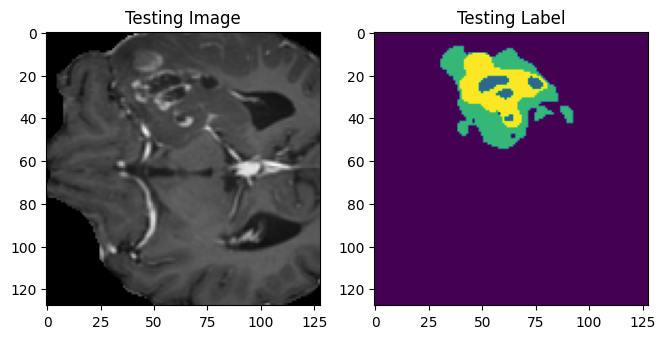

In [ ]:
img_num = 425

test_img = np.load("./post_process_data/input_data_128/train/images/"+str(img_num)+".npy")

test_mask = np.load("./post_process_data/input_data_128/val/masks/"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)

n_slice=50
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.show()

In [ ]:
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    '''
    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding='same')(x)  # Use Conv3D instead of Conv4D
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=-1)(conv)  # Update the axis to -1 for BatchNormalization
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding='same')(conv)  # Use Conv3D instead of Conv4D
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=-1)(conv)  # Update the axis to -1 for BatchNormalization
    # conv = layers.Activation('relu')(conv)  # Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv3D(size, kernel_size=(1, 1, 1), padding='same')(x)  # Use Conv3D instead of Conv2D
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=-1)(shortcut)  # Update the axis to -1 for BatchNormalization

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)  # Activation after addition with shortcut (Original residual block)
    return res_path

def ResUNet(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    '''
    Residual UNet
    '''
    # network structure
    FILTER_NUM = 32  # number of basic filters for the first layer
    FILTER_SIZE = 3  # size of the convolutional filter
    UP_SAMP_SIZE = 2  # size of upsampling filters
    NUM_CLASSES = num_classes
    dropout_rate = 0.0
    batch_norm = True

    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS), name='input')
    axis = 4  # Update the axis to 4 since the input shape includes 5 dimensions (batch size, height, width, depth, channels)

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_64 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_64)
    # DownRes 2
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_32)
    # DownRes 3
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_16)
    # DownRes 4
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 5, upsampling + double residual convolution
    up_16 = layers.UpSampling3D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 6
    up_32 = layers.UpSampling3D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    up_64 = layers.UpSampling3D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    conv_final = layers.Conv3D(num_classes, kernel_size=(1, 1, 1))(up_conv_64)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    outputs = layers.Activation('softmax')(conv_final)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
import os
import numpy as np
from keras.losses import CategoricalCrossentropy
from keras import optimizers

def launch_model(train_img_dir, train_mask_dir, val_img_dir, val_mask_dir, batch_size, num_epochs):
    # Define directory paths for training and validation data
    train_img_list = os.listdir(train_img_dir)
    train_mask_list = os.listdir(train_mask_dir)
    val_img_list = os.listdir(val_img_dir)[:10]
    val_mask_list = os.listdir(val_mask_dir)[:10]

    # Calculate steps per epoch for training and validation
    steps_per_epoch = len(train_img_list) // batch_size
    val_steps_per_epoch = len(val_img_list) // batch_size

    # Define image data generators
    train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
    val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

    with tf.device('GPU:0'):
        model = ResUNet(128, 128, 128, 3, 4)
        model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy', dice_coef, precision, sensitivity])

        # Train the model
        history = model.fit(train_img_datagen,
                            steps_per_epoch=steps_per_epoch,
                            epochs=num_epochs,
                            verbose=1,
                            validation_data=val_img_datagen,
                            validation_steps=val_steps_per_epoch)

        # Plot training and validation metrics
        print("Plotting Training and Validation Metrics...")
        Accuracy_Graph(history)  # Assuming these functions use the model history
        Dice_coefficient_Graph(history)
        Loss_Graph(history)

        # Save the trained models
        print("Saving Trained Models...")
        model.save('./final_models/ResUNet20.keras')

# Define directory paths for training and validation data
train_img_dir = "./post_process_data/input_data_128/train/images/"  # Replace with your paths
train_mask_dir = "./post_process_data/input_data_128/train/masks/"
val_img_dir = "./post_process_data/input_data_128/val/images/"
val_mask_dir = "./post_process_data/input_data_128/val/masks/"

# Define batch size
batch_size = 2
num_epochs = 50
launch_model(train_img_dir, train_mask_dir, val_img_dir, val_mask_dir, batch_size, num_epochs)

Epoch 1/20
460/460 [==============================] - 1164s 3s/step - loss: 0.8873 - accuracy: 0.9472 - dice_coef: 0.4398 - precision: 0.7551 - sensitivity: 0.2812 - val_loss: 0.6607 - val_accuracy: 0.9537 - val_dice_coef: 0.5509 - val_precision: 0.9757 - val_sensitivity: 0.4155
Epoch 2/20
460/460 [==============================] - 1154s 3s/step - loss: 0.4857 - accuracy: 0.9733 - dice_coef: 0.6399 - precision: 0.9838 - sensitivity: 0.6223 - val_loss: 0.4772 - val_accuracy: 0.9488 - val_dice_coef: 0.6883 - val_precision: 0.9704 - val_sensitivity: 0.5849
Epoch 3/20
460/460 [==============================] - 1155s 3s/step - loss: 0.2981 - accuracy: 0.9775 - dice_coef: 0.7653 - precision: 0.9840 - sensitivity: 0.6605 - val_loss: 0.2466 - val_accuracy: 0.9751 - val_dice_coef: 0.8105 - val_precision: 0.9828 - val_sensitivity: 0.6160
Epoch 4/20
460/460 [==============================] - 1155s 3s/step - loss: 0.2019 - accuracy: 0.9797 - dice_coef: 0.8389 - precision: 0.9847 - sensitivity: 0.6

In [ ]:
import tensorflow as tf
from keras.layers import Layer, Input, Conv3D, Concatenate, Dense, BatchNormalization, Dropout
from keras.models import Model

class MaskingLayer(Layer):
    def __init__(self, scale_factor=2, **kwargs):
        self.scale_factor = scale_factor
        super(MaskingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mask = self.add_weight(shape=input_shape[-1], initializer='ones', trainable=True)
        super(MaskingLayer, self).build(input_shape)

    def call(self, inputs):
        scaled_mask = self.mask * self.scale_factor
        masked_output = inputs * scaled_mask
        return masked_output

tf.keras.utils.register_keras_serializable(package="CustomLayers")(MaskingLayer)

class CouplingLayer(Layer):
    def __init__(self, scale_factor=2, **kwargs):
        self.scale_factor = scale_factor
        super(CouplingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.scale = self.add_weight(shape=input_shape[-1], initializer='zeros', trainable=True)
        self.translation = self.add_weight(shape=input_shape[-1], initializer='zeros', trainable=True)
        super(CouplingLayer, self).build(input_shape)

    def call(self, inputs, mask):
        masked_exp_scale = tf.exp(self.scale * self.scale_factor) * mask
        y = inputs * masked_exp_scale + self.translation
        return y

tf.keras.utils.register_keras_serializable(package="CustomLayers")(CouplingLayer)
def build_maf_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes, num_flows):
    # Input layer
    input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

    # Incorporate downsampling layers
    x = Conv3D(filters=64, kernel_size=(2, 2, 2), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)  # Add downsampling layer

    # Add more downsampling layers
    x = Conv3D(filters=128, kernel_size=(2, 2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)  # Add downsampling layer

    # Incorporate upsampling layers
    x = UpSampling3D(size=(2, 2, 2))(x)  # Add upsampling layer
    x = Conv3D(filters=64, kernel_size=(2, 2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Add more upsampling layers
    x = UpSampling3D(size=(2, 2, 2))(x)  # Add upsampling layer
    x = Conv3D(filters=32, kernel_size=(2, 2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Incorporate MAF flow architecture
    for _ in range(num_flows):
        mask = MaskingLayer()(x)  # Apply masking layer
        x = CouplingLayer()(x, mask)  # Pass the masked output to the coupling layer
        x = Dropout(0.2)(x)  # Adding dropout layer to reduce overfitting

    # Segmentation output layer
    segmentation_output = Conv3D(filters=num_classes, kernel_size=(1, 1, 1), activation='softmax', padding='same')(x)

    # Create the MAF model
    model = Model(inputs=input_layer, outputs=segmentation_output)
    return model

In [ ]:
import os
import numpy as np
from keras.losses import CategoricalCrossentropy
from keras import optimizers

def launch_model(train_img_dir, train_mask_dir, val_img_dir, val_mask_dir, batch_size, num_epochs):
    # Define directory paths for training and validation data
    train_img_list = os.listdir(train_img_dir)
    train_mask_list = os.listdir(train_mask_dir)
    val_img_list = os.listdir(val_img_dir)[:10]
    val_mask_list = os.listdir(val_mask_dir)[:10]

    # Calculate steps per epoch for training and validation
    steps_per_epoch = len(train_img_list) // batch_size
    val_steps_per_epoch = len(val_img_list) // batch_size

    # Define image data generators
    train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
    val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

    with tf.device('GPU:0'):
        num_flows = 2  # Number of MAF flows
        model = build_maf_model(128, 128, 128, 3, 4, num_flows)
        model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy', dice_coef, precision, sensitivity])

        # Train the model
        history = model.fit(train_img_datagen,
                            steps_per_epoch=steps_per_epoch,
                            epochs=num_epochs,
                            verbose=1,
                            validation_data=val_img_datagen,
                            validation_steps=val_steps_per_epoch)

        # Plot training and validation metrics
        print("Plotting Training and Validation Metrics...")
        Accuracy_Graph(history)  # Assuming these functions use the model history
        Dice_coefficient_Graph(history)
        Loss_Graph(history)

        # Save the trained models
        print("Saving Trained Models...")
        model.save('./final_models/MAF20.keras')

# Define directory paths for training and validation data
train_img_dir = "./post_process_data/input_data_128/train/images/"  # Replace with your paths
train_mask_dir = "./post_process_data/input_data_128/train/masks/"
val_img_dir = "./post_process_data/input_data_128/val/images/"
val_mask_dir = "./post_process_data/input_data_128/val/masks/"

# Define batch size
batch_size = 2
num_epochs = 20
launch_model(train_img_dir, train_mask_dir, val_img_dir, val_mask_dir, batch_size, num_epochs)

1/1 [==============================] - 4s 4s/step
Accuracy:  0.9681382179260254
Precision:  0.878340856421755
Sensitivity:  0.43287963647936095


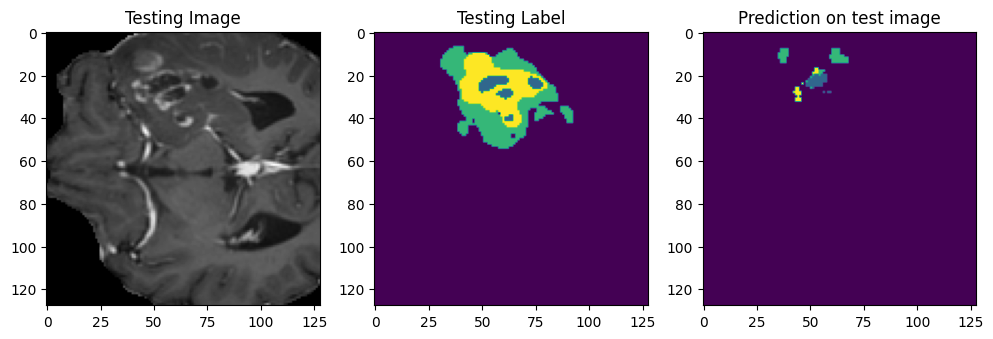

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score

model1 = load_model('./final_models/MAF10.keras', compile=False)

img_num = 425

test_img = np.load("./post_process_data/input_data_128/val/images/"+str(img_num)+".npy")

test_mask = np.load("./post_process_data/input_data_128/val/masks/"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
ensemble_predictions = model1.predict(test_img_input)

ensemble_predictions_argmax=np.argmax(ensemble_predictions, axis=4)[0,:,:,:]

print('Accuracy: ', accuracy_score(test_mask_argmax.flatten(), ensemble_predictions_argmax.flatten()))
print('Precision: ', precision_score(test_mask_argmax.flatten(), ensemble_predictions_argmax.flatten(), average='macro'))
print('Sensitivity: ', recall_score(test_mask_argmax.flatten(), ensemble_predictions_argmax.flatten(), average='macro'))

n_slice=50
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(ensemble_predictions_argmax[:,:, n_slice])

plt.show()

1/1 [==============================] - 1s 504ms/step
Accuracy:  0.9815635681152344
Precision:  0.719720749045216
Sensitivity:  0.7753204324833132


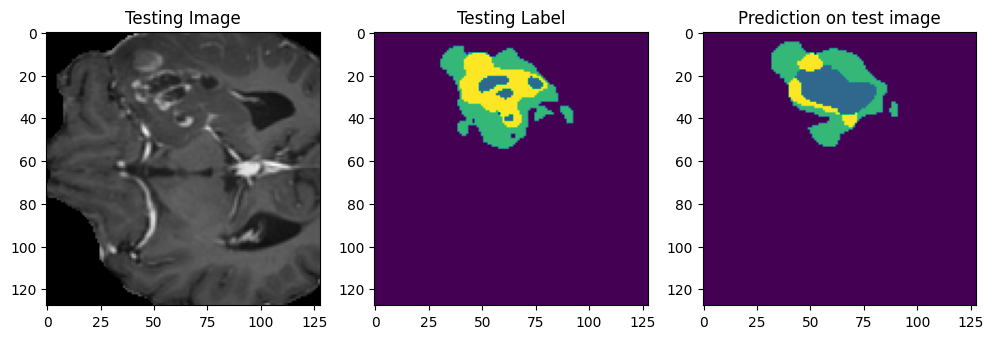

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score

model1 = load_model('./final_models/ResUNet10.keras', compile=False)

img_num = 425

test_img = np.load("./post_process_data/input_data_128/val/images/"+str(img_num)+".npy")

test_mask = np.load("./post_process_data/input_data_128/val/masks/"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
ensemble_predictions = model1.predict(test_img_input)

ensemble_predictions_argmax=np.argmax(ensemble_predictions, axis=4)[0,:,:,:]

print('Accuracy: ', accuracy_score(test_mask_argmax.flatten(), ensemble_predictions_argmax.flatten()))
print('Precision: ', precision_score(test_mask_argmax.flatten(), ensemble_predictions_argmax.flatten(), average='macro'))
print('Sensitivity: ', recall_score(test_mask_argmax.flatten(), ensemble_predictions_argmax.flatten(), average='macro'))

n_slice=50
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(ensemble_predictions_argmax[:,:, n_slice])
plt.show()

1/1 [==============================] - 7s 7s/step
Accuracy:  0.9771537780761719
Precision:  0.7880077614502563
Sensitivity:  0.6796572226860371


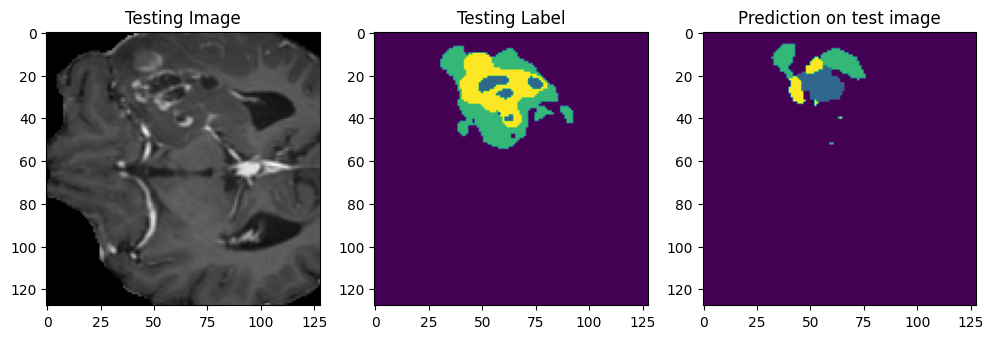

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict_base_model(test_img_input):
    # Make predictions using the limited validation data
    pred1 = model1.predict(test_img_input)
    pred2 = model2.predict(test_img_input)

    # Ensemble the predictions by taking the average
    ensemble_predictions = (pred1 + pred2) / 2

    return ensemble_predictions

model1 = load_model('./final_models/MAF10.keras', compile=False)
model2 = load_model('./final_models/ResUNet10.keras', compile=False)

img_num = 425

test_img = np.load("./post_process_data/input_data_128/val/images/"+str(img_num)+".npy")

test_mask = np.load("./post_process_data/input_data_128/val/masks/"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
ensemble_predictions = predict_base_model(test_img_input)

ensemble_predictions_argmax=np.argmax(ensemble_predictions, axis=4)[0,:,:,:]

print('Accuracy: ', accuracy_score(test_mask_argmax.flatten(), ensemble_predictions_argmax.flatten()))
print('Precision: ', precision_score(test_mask_argmax.flatten(), ensemble_predictions_argmax.flatten(), average='macro'))
print('Sensitivity: ', recall_score(test_mask_argmax.flatten(), ensemble_predictions_argmax.flatten(), average='macro'))

n_slice=50
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(ensemble_predictions_argmax[:,:, n_slice])
plt.show()

In [ ]:
%%writefile index.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Image Prediction</title>
</head>
<body>
    <h1>Upload an Image for Prediction</h1>
    <form action="/predict" method="post" enctype="multipart/form-data">
        <input type="file" name="file" accept=".npy">
        <button type="submit">Predict</button>
    </form>
</body>
</html>

Writing index.html


In [ ]:
!pip install flask
!pip install flask-ngrok

In [ ]:
!pip install pyngrok

In [ ]:
import tensorflow as tf
from keras.layers import Layer, Input, Conv3D, Concatenate, Dense, BatchNormalization, Dropout
from keras.models import Model

class MaskingLayer(Layer):
    def __init__(self, scale_factor=2, **kwargs):
        self.scale_factor = scale_factor
        super(MaskingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mask = self.add_weight(shape=input_shape[-1], initializer='ones', trainable=True)
        super(MaskingLayer, self).build(input_shape)

    def call(self, inputs):
        scaled_mask = self.mask * self.scale_factor
        masked_output = inputs * scaled_mask
        return masked_output

tf.keras.utils.register_keras_serializable(package="CustomLayers")(MaskingLayer)

class CouplingLayer(Layer):
    def __init__(self, scale_factor=2, **kwargs):
        self.scale_factor = scale_factor
        super(CouplingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.scale = self.add_weight(shape=input_shape[-1], initializer='zeros', trainable=True)
        self.translation = self.add_weight(shape=input_shape[-1], initializer='zeros', trainable=True)
        super(CouplingLayer, self).build(input_shape)

    def call(self, inputs, mask):
        masked_exp_scale = tf.exp(self.scale * self.scale_factor) * mask
        y = inputs * masked_exp_scale + self.translation
        return y

tf.keras.utils.register_keras_serializable(package="CustomLayers")(CouplingLayer)

__main__.CouplingLayer

In [ ]:
from flask import Flask, request, render_template
from werkzeug.utils import secure_filename
from pyngrok import ngrok
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from io import BytesIO
import base64

uploads_dir = 'uploads'
if not os.path.exists(uploads_dir):
    os.makedirs(uploads_dir)

app = Flask(__name__)

# Load the Keras models
model1 = load_model('./final_models/MAF20.keras', compile=False)
model2 = load_model('./final_models/ResUNet20.keras', compile=False)

def ensemble_predict(test_img_input):
    # Make predictions using the limited validation data
    pred1 = model1.predict(test_img_input)
    pred2 = model2.predict(test_img_input)

    # Ensemble the predictions by taking the average
    ensemble_predictions = (pred1 + pred2) / 2

    return ensemble_predictions

@app.route("/", methods=["GET", "POST"])
def home():
    if request.method == "POST":
        file = request.files['file']
        file_path = f"./uploads/{secure_filename(file.filename)}"
        file.save(file_path)

        test_img = np.load(file_path)
        test_img_input = np.expand_dims(test_img, axis=0)
        ensemble_predictions = ensemble_predict(test_img_input)
        ensemble_predictions_argmax = np.argmax(ensemble_predictions, axis=4)[0, :, :, :]

        # Visualization
        n_slice = 50
        plt.figure(figsize=(12, 8))
        plt.subplot(231)
        plt.title('Uploaded Image')
        plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
        plt.subplot(232)
        plt.title('Segmentation Mask')
        plt.imshow(ensemble_predictions_argmax[:, :, n_slice])

        # Convert the plot to a base64 encoded string
        img = BytesIO()
        plt.savefig(img, format='png')
        img.seek(0)
        plot_data = base64.b64encode(img.getvalue()).decode()
        plt.close()

        return render_template("result.html", plot_data=plot_data)
    return render_template("index.html")

ngrok.set_auth_token("2c2mJAbHP1xSjVUNU3pTcv4MTEf_3V1ENWd6SUm8BsHFvy2tN")
public_url = ngrok.connect(5000).public_url
print(f"To access the Global link please click {public_url}")

app.run(port=5000)

To access the Global link please click https://86aa-35-221-4-205.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [08/Feb/2024 05:38:21] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Feb/2024 05:38:22] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 7s 7s/step


INFO:werkzeug:127.0.0.1 - - [08/Feb/2024 05:38:48] "POST / HTTP/1.1" 200 -
